<a href="https://colab.research.google.com/github/MatteoGuglielmi-tech/Polarity-and-Subjectivity-Detection/blob/main/src/MyModel/NTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NTN (Neural Tensor Network) [[reference_paper](https://proceedings.neurips.cc/paper/2013/file/b337e84de8752b27eda3a12363109e80-Paper.pdf)]

<u><i>Goal</i></u> : state if two entities $(e_1, e_2)$ are in a certain relationship $R$.   
>Ex. defines whehter $$(e_1, R, e_2) = (\text{Bengal tiger}, \text{has part}, \text{tail})$$ is true and with which certainty.

- $e_1$ and $e_2$ are vector representations or features of the two entities.
- NTN, unlike a linear canoncical NN layer, uses a bilinear tensor layer that directly relates two entity vectors across differet dimensions.
- Model computes a score of how likely it is two entities are in a specific position following : $$g(e_1, R, e_2) = u_R^Tf\biggr(e_i^T W_R^{[1:K]}e_2+V_R \begin{align}
    \begin{bmatrix}
           e_{1} \\
           e_{2} \\
         \end{bmatrix}
  \end{align} + b_R\Biggl)$$  
where : 
- $f=\tanh$
- $W_R^{[1:K]} \in \mathbb{R}^{d\times d\times k}$ is a multi-dimensional tensor
- $e_1^TW_R^{[1:k]}e_2=h\in\mathbb{R}$ is the bilinear tensor
- $V_R \in \mathbb{R}^{k\times2d}$, $U \in \mathbb{R}^K$, $b_R\in \mathbb{R}^K$ are NN parameters




##### pytorch trials

In [3]:
import torch
import torch.nn as nn
from typing import Tuple, List
import numpy as np
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import keras.backend as K
import tensorflow as tf

In [56]:
class NeuralTensorNetwork(nn.Module):
    def __init__(self, output_dim: int, input_dim: int, activation: str="tanh", mean: float=0.0, std: float=1.0):
        
        super(NeuralTensorNetwork, self).__init__()

        # setting input and output dimensions
        self.k = output_dim
        self.d = input_dim # e1,e2

        # setting mean and std for random initialization
        self.mean = mean
        self.std = std

        self.activation = activation

        # parameters has been used in order to consider W, V, b as model parameters
        # inference -> they'll be optimized

        # normal sampling -> https://pytorch.org/docs/stable/generated/torch.normal.html
        # parameter -> https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter
        self.W = nn.Parameter(torch.normal(self.mean, self.std, size=(self.k, self.d, self.d)))
        self.V = nn.Parameter(torch.normal(self.mean, self.std, size=(2*self.d, self.k)))
        self.b = nn.Parameter(torch.zeros(size=(self.d,)))
        
        print(f"self.W : {torch.Tensor.size(self.W)}")
        print(f"self.V : {torch.Tensor.size(self.V)}")
        print(f"self.b : {torch.Tensor.size(self.b)}")
        
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif self.activation == 'relu':
            self.activation = nn.ReLU()
        # checking for a good activation function
        else:
            raise ValueError('Possible activation choices are tanh, sigmoid or ReLU')

    def forward(self, inputs: List[torch.Tensor]) -> torch.Tensor:

        # getting the entities
        e1 = inputs[0]
        e2 = inputs[1]
        print(f"e1.shape : {torch.Tensor.size(e1)}")
        print(f"e2.shape : {torch.Tensor.size(e2)}")
        print(f"self.W[0] : {torch.Tensor.size(self.W[0])}")
        print(f"self.V : {torch.Tensor.size(self.V)}")
        print(f"self.bias : {torch.Tensor.size(self.b)}")
        print(f"batch_size : {torch.clone(e1).cpu().numpy().shape[0]}")
        print(f"k : {self.k}")


        # input tensor should be of shape (batch_size, padded_length, 768)
        batch_size = torch.clone(e1).cpu().numpy().shape[0]
        k = self.k
        d = self.d

        print(f"dot prod : {torch.matmul(e1, self.W[0])}")
        print(f"dot prod size: {torch.Tensor.size(torch.matmul(e1, self.W[0]))}")

        # bilinear tensor + bias
        bil_bias = [torch.sum((e2 * torch.matmul(e1, self.W[0])) + self.b, axis=1)]
        
        for i in range(1,k):
            bil_bias.append(torch.sum((e2*torch.matmul(e1, self.W[i])) + self.b, axis=1))
        
        bil_bias = torch.cat(bil_bias, axis=0)
        bil_bias = torch.reshape(bil_bias, (batch_size, k))

        # Vr * [e1, e2]
        rest = torch.matmul(torch.cat([e1,e2]), self.V)

        #e1_R_e2 = bil_bias + rest

        # applying activation
        #f = self.activation(e1_R_e2)
        #return f

In [42]:
def batching_data(dataset, batch_size: int=64) -> torch.utils.data.DataLoader:
    dataloader = DataLoader(dataset=dataset, sampler=RandomSampler(dataset), batch_size=batch_size, shuffle=False)
    return dataloader

In [43]:
ll = []
i = np.array([1,2,3,4,5,6,7,8,9,10])
ll.append(i)
for k in range(0,10):
    ll.append(np.zeros(i.shape))

print(ll)


l = []

j = np.array([11,12,13,14,15,16,17,18,19,20])
l.append(j)
for z in range(0,10):
    l.append(np.ones(j.shape))

print(l)

print(np.array(l).shape)
print(np.array(ll).shape)

y = np.random.random((len(l),1))
y.shape

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
[array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1.,

(11, 1)

In [44]:
e1_dataloader = batching_data(np.array(ll), batch_size=4)
e2_dataloader = batching_data(np.array(l), batch_size=4)

In [45]:
e1_dataloader

In [46]:
e2_dataloader

In [47]:
for idx, i in enumerate(iter(e2_dataloader)):
    for element in i :
        print(idx, element)

0 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
0 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
0 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
0 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
1 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
1 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
1 tensor([11., 12., 13., 14., 15., 16., 17., 18., 19., 20.], dtype=torch.float64)
1 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
2 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
2 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
2 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)


In [48]:
len(iter(e1_dataloader))

for i in range (len(iter(e1_dataloader))):
  print(next(iter(e1_dataloader)))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]],
       dtype=torch.float64)
tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
       dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)


In [49]:
len(iter(e2_dataloader))

for i in range (len(iter(e2_dataloader))):
  print(next(iter(e2_dataloader)))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=torch.float64)
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=torch.float64)
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=torch.float64)


In [50]:
def get_mse() -> torch.nn.MSELoss:
    return nn.MSELoss()

In [51]:
def get_optimizer(model, lr):
    return torch.optim.Adam(model.parameters(), lr)

In [52]:
def training_step(model, e1_dataloader, e2_dataloader, device='cuda'):
    # converting the two dataloaders in iterators
    print('training')
    e1_iterator = iter(e1_dataloader)
    e2_iterator = iter(e2_dataloader)

    # getting lengths 
    iter1_length = len(e1_iterator)
    iter2_length = len(e2_iterator)

    flag = 0
    loss = get_mse()
    optimizer = get_optimizer(model, 0.001)

    model.train()

    if iter1_length > iter2_length:
        flag = 1
    elif iter2_length > iter1_length:
        flag = 2

    if flag==1:
        for i in range(iter2_length):
        # if the second entity's vector is longer than the first one
        # I need to deal with this case
        # With the devised solution, once the first iterator has reached the end 
        # it will be reinitialized 
            try:
                e1_input = next(e1_iterator)
                e1_input = e1_input.to(device)
            except:
                e1_iterator = iter(e1_dataloader)
                e1_input = next(e1_iterator)
                e1_input = e1_input.to(device)

            # at this point, al inputs are loaded on GPU
            outputs = model([e1_input, e2_input]) # call method
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            print(f'outputs: {outputs}')

    elif flag==2:
        for i in range(iter1_length):
            try:
                e2_input = next(e2_iterator)
                e2_input = e2_input.to(device)
            except:
                e2_iterator = iter(e2_dataloader)
                e2_input = next(e2_iterator)
                e2_input = e2_input.to(device)

            outputs = model([e1_input, e2_input]) # call method
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    elif flag==0:
        for e1, e2 in zip(e1_iterator, e2_iterator):
            #for element1, element2 in zip(e1,e2):
                # in case they have the same length
                #for i in range(iter1_length):
            #    e1_input = element1.to(device)
            #    e2_input = element2.to(device)
                #print(e1_input)
                #print(e2_input)
            #    outputs = model([e1_input, e2_input]) # forward method
        
            #    loss.backward()
            #    optimizer.step()
            #    optimizer.zero_grad()
            
            # in this way I'm extracting the batches
            print(f"e1 : {e1.shape}")
            print(f"e2 : {e2.shape}")

            e1_input = e1.to(device)
            e2_input = e2.to(device)
            outputs = model([e1_input, e2_input]) # forward method


            #loss.backward()
            #optimizer.step()
            #optimizer.zero_grad()

In [53]:
def main(dataloaders, epochs=5, device='cuda'):
    model = NeuralTensorNetwork(output_dim=32, input_dim=10)
    model = model.double().to(device)
    for e in range(epochs):
    # def training_step(model, e1_dataloader, e2_dataloader, device='cuda'):
        training_step(model, dataloaders[0], dataloaders[1]) 
        print(e)
    print('Traning done')

In [57]:
main([e1_dataloader, e2_dataloader])

self.W : torch.Size([32, 10, 10])
self.V : torch.Size([20, 32])
self.b : torch.Size([10])
training
e1 : torch.Size([4, 10])
e2 : torch.Size([4, 10])
e1.shape : torch.Size([4, 10])
e2.shape : torch.Size([4, 10])
self.W[0] : torch.Size([10, 10])
self.V : torch.Size([20, 32])
self.bias : torch.Size([10])
batch_size : 4
k : 32
dot prod : tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [-18.9876,  25.5987, -12.2584,  -4.1140, -15.9250,  18.3823, -16.7758,
          17.2009,  -6.5892, -18.3146]], device='cuda:0', dtype=torch.float64,
       grad_fn=<MmBackward0>)
dot prod size: torch.Size([4, 10])


RuntimeError: ignored

### to collapse

In [ ]:
import numpy as np


# Dummy training data
x_train1 = np.random.random((1000, 300))
x_train2 = np.random.random((1000, 300))
y_train = np.random.random((1000, 1))

# Dummy validation data
x_val1 = np.random.random((100, 300))
x_val2 = np.random.random((100, 300))
y_val = np.random.random((100, 1))


print ('Shape of Training Data: ', x_train1.shape, x_train2.shape, y_train.shape)
print ('Shape of Validation Data', x_val1.shape, x_val2.shape, y_val.shape)

In [ ]:
x1, x2 = batching_data([x_train1, x_train2])

In [ ]:
type(x1)

In [ ]:
type(x2)

## Tensrflow Version

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import backend as K  # in keras simple computations are not handled directly but it relies on a well optimized tensor handler library
from keras.layers import Layer
from keras.layers import Input, Dense
from keras.models import Model

In [17]:
class NeuralTensorLayer(Layer):
    def __init__(self, output_dim, input_dim, activation= None):
        super().__init__()
        self.output_dim = output_dim #The k in the formula
        self.input_dim = input_dim   #The d in the formula
        self.activation = activation #The f function in the formula
        
    # called the first time call is called
    def build(self, input_shape):
        #The initialisation parameters
        self.mean = 0.0 
        self.stddev = 1.0
        dtype = 'float32'
        self.seed = 1
        
        #The output and the inut dimension
        k = self.output_dim
        d = self.input_dim
        
        #Initialise the variables to be trained. The variables are according to the
        #function defined.
        self.W = K.variable(K.random_normal((k,d,d), self.mean, self.stddev,
                               dtype=dtype, seed=self.seed))
        self.V = K.variable(K.random_normal((2*d,k), self.mean, self.stddev,
                               dtype=dtype, seed=self.seed))
        self.b = K.zeros((self.input_dim,))
        
        #Set the variables to be trained.
        self._trainable_weights = [self.W, self.V, self.b]
        
    def call(self, inputs):
        
        #Get Both the inputs
        e1 = inputs[0]
        e2 = inputs[1]

        tf.print("\n")
        tf.print("e1.shape : ", tf.shape(e1))
        tf.print("e2.shape : ", tf.shape(e2))
        tf.print("W[0].shape : ", tf.shape(self.W[0]))
        tf.print("V.shape : ", tf.shape(self.V))
        tf.print("b.shape : ", tf.shape(self.b))
        tf.print("batch_size : ", K.shape(e1)[0])

        #Get the batch size
        batch_size = K.shape(e1)[0]
        
        #The output and the inut dimension
        k = self.output_dim
        d = self.input_dim

        #The first term in the function which is the bilinear product is calculated here.
        first_term_k = [K.sum((e2 * K.dot(e1, self.W[0])) + self.b, axis=1)]
        tf.print("K.dot : " , K.dot(e1,self.W[0]))
        tf.print("K.dot shape : " , tf.shape(K.dot(e1,self.W[0])))
        for i in range(1, k):
            temp = K.sum((e2 * K.dot(e1, self.W[i])) + self.b, axis=1)
            first_term_k.append(temp)
        first_term = K.concatenate(first_term_k, axis=0) 
        tf.print("first_term size :", tf.shape(first_term))
        
        first_term = K.reshape(first_term, (batch_size, k))

        tf.print("first_term size :", tf.shape(first_term))

        #The second term in the function is calculated here.
        second_term = K.dot(K.concatenate([e1,e2]), self.V)
        
        #Sum of the two terms to get the final function
        z =  first_term + second_term
 
        # The activation is selected here
        if (self.activation == None):
            return z
        elif (self.activation == 'tanh'):
            return K.tanh(z)
        elif (self.activation == 'relu'):
            tf.print(K.relu(z))
            return K.relu(z)
        else :
            print ('Activation not found')
        

In [18]:
#Here Define the model
vector1 = Input(shape=(10,), dtype='float32')
vector2 = Input(shape=(10,), dtype='float32')
BilinearLayer = NeuralTensorLayer(output_dim=32, input_dim=10, 
                                  activation= 'relu')([vector1, vector2])

g = Dense(1)(BilinearLayer)

#The g or the output of the modelled function.
model = Model(inputs=[vector1, vector2], outputs=[g])

#Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)
#The summary of the model.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 neural_tensor_layer (NeuralTen  (None, 32)          3850        ['input_1[0][0]',                
 sorLayer)                                                        'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1)            33          ['neural_tensor_layer[0][0]']

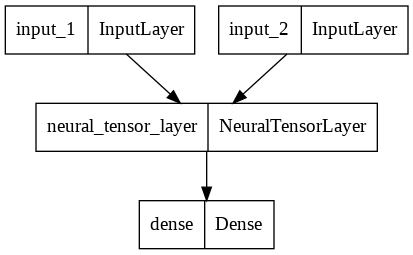

In [19]:
from keras.utils.vis_utils import plot_model

plot_model(model)

In [20]:
ll = []
i = np.array([1,2,3,4,5,6,7,8,9,10])
ll.append(i)
for k in range(0,10):
    ll.append(np.zeros(i.shape))

print(ll)


l = []

j = np.array([11,12,13,14,15,16,17,18,19,20])
l.append(j)
for z in range(0,10):
    l.append(np.ones(j.shape))

print(l)

print(np.array(l).shape)
print(np.array(ll).shape)

y = np.random.random((len(l),1))
y.shape

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
[array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1.,

(11, 1)

In [21]:
model.fit(([np.array(ll), np.array(l)]), y, batch_size=4, epochs=10)

Epoch 1/10


e1.shape :  [4 10]
e2.shape :  [4 10]
W[0].shape :  [10 10]
V.shape :  [20 32]
b.shape :  [10]
batch_size :  4
K.dot :  [[0 0 0 ... 0 0 0]
 [-17.6482086 -11.4627132 -17.8698082 ... -18.0689449 -13.3989353 -3.01333237]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
K.dot shape :  [4 10]
first_term size : [128]
first_term size : [4 32]
[[3.45256114 0 6.53031635 ... 0 0 6.312922]
 [76.2542572 668.639221 96.4868088 ... 652.081421 0 97.0310669]
 [3.45256114 0 6.53031635 ... 21.7018967 0 6.312922]
 [3.45256114 646.196655 6.53031635 ... 1975.80408 0 6.312922]]
1/3 [=========>....................] - ETA: 5s - loss: 231139.5312

e1.shape :  [4 10]
e2.shape :  [4 10]
W[0].shape :  [10 10]
V.shape :  [20 32]
b.shape :  [10]
batch_size :  4
K.dot :  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
K.dot shape :  [4 10]
first_term size : [128]
first_term size : [4 32]
[[3.43256068 0.463235319 6.53031635 ... 0.267200172 0 6.31292152]
 [3.43256068 0.463235319 6.530316

In [22]:
import numpy as np


# Dummy training data
x_train1 = np.random.random((1000, 300))
x_train2 = np.random.random((1000, 300))
y_train = np.random.random((1000, 1))

# Dummy validation data
x_val1 = np.random.random((100, 300))
x_val2 = np.random.random((100, 300))
y_val = np.random.random((100, 1))

print ('Shape of Training Data: ', x_train1.shape, x_train2.shape, y_train.shape)
print ('Shape of Validation Data', x_val1.shape, x_val2.shape, y_val.shape)


Shape of Training Data:  (1000, 300) (1000, 300) (1000, 1)
Shape of Validation Data (100, 300) (100, 300) (100, 1)


In [23]:
#Here Define the model
vector1 = Input(shape=(300,), dtype='float32')
vector2 = Input(shape=(300,), dtype='float32')
BilinearLayer = NeuralTensorLayer(output_dim=32, input_dim=300, 
                                  activation= 'relu')([vector1, vector2])

g = Dense(1)(BilinearLayer)

#The g or the output of the modelled function.
model = Model(inputs=[vector1, vector2], outputs=[g])

#Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)
#The summary of the model.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 neural_tensor_layer_1 (NeuralT  (None, 32)          2899500     ['input_3[0][0]',                
 ensorLayer)                                                      'input_4[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1)            33          ['neural_tensor_layer_1[0][

In [ ]:
model.fit([x_train1, x_train2], y_train,
          batch_size=64, epochs=10,
          validation_data=([x_val1, x_val2], y_val))

Epoch 1/10


e1.shape :  [64 300]
e2.shape :  [64 300]
W[0].shape :  [300 300]
V.shape :  [600 32]
b.shape :  [300]
batch_size :  64
K.dot :  [[6.76094437 6.98399973 19.4028091 ... -3.13920641 -12.876812 9.40279579]
 [15.5103493 0.561729431 17.5366955 ... 7.54815578 -0.585941911 9.23697]
 [16.8529282 0.700781822 11.7601309 ... 6.05116463 -0.640530586 9.82060432]
 ...
 [21.9679337 -5.39707613 14.7158356 ... 0.481683731 -0.444964647 10.8135395]
 [22.9722 0.177963614 7.12797165 ... -0.695707202 -12.2166262 17.6944237]
 [12.4238987 3.5294 3.2324667 ... 6.2666297 -1.8665247 1.08624315]]
K.dot shape :  [64 300]
first_term size : [2048]
first_term size : [64 32]
[[0 28.1564159 11.2468777 ... 4.79767132 55.6609192 0]
 [0 97.3384781 0 ... 48.6693954 104.389427 0]
 [0 0 0 ... 11.9258289 2.66395569 24.2900982]
 ...
 [0 0 0 ... 0 30.7423706 0]
 [94.2552643 3.3978076 0 ... 0 116.117584 210.845139]
 [0 0 0 ... 0 5.80917358 9.0389452]]
 1/16 [>.............................] - ETA: 41s - loss: 4881.52

Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:


Error in sys.excepthook:
Traceback (most recent call last):


During handling of the above exception, another exception occurred:



Original exception was:
Traceback (most recent call last):


During handlin

ZMQError: ignored

11/16 [===================>..........] - ETA: 0s - loss: 2.4245

e1.shape :  [64 300]
e2.shape :  [64 300]
W[0].shape :  [300 300]
V.shape :  [600 32]
b.shape :  [300]
batch_size :  64
K.dot :  [[8.25871944 -1.95493412 2.5797987 ... -4.3628273 -10.8539181 0.0262403488]
 [12.8683844 0.349162102 8.13313293 ... -11.4603233 -5.5699892 7.00524712]
 [8.21937943 0.604962587 13.7804508 ... 5.65411091 -11.062191 10.1893883]
 ...
 [19.1256866 -5.59696388 10.8674393 ... -2.2344718 0.678822041 2.27854061]
 [13.3571281 -10.4184351 19.5494766 ... 3.90953112 2.79998302 8.5486412]
 [21.046526 -3.97724771 6.50554132 ... -2.9204092 -2.71136761 0.706594467]]
K.dot shape :  [64 300]
first_term size : [2048]
first_term size : [64 32]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


e1.shape :  [64 300]
e2.shape :  [64 300]
W[0].shape :  [300 300]
V.shape :  [600 32]
b.shape :  [300]
batch_size :  64
K.dot :  [[11.6795921 -3.51438665 1